**# Data cleaning**

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
cash = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')

In [6]:
cash.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,NaN,NaN,804.0,NaN,NaN,NaN,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,NaN,NaN,231.0,NaN,NaN,NaN,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,NaN,NaN,191.0,NaN,NaN,NaN,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,NaN,NaN,761.0,NaN,NaN,NaN,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,NaN,NaN,7686.0,NaN,NaN,NaN,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [ ]:
print(cash['user_id'].dtype)


float64


In [12]:
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

In [13]:
fees.head()


,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [37]:
print(fees['cash_request_id'].dtype)

float64


In [43]:
fees.info()

<class 'pandas.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21061 non-null  int64              
 1   cash_request_id  21057 non-null  float64            
 2   type             21061 non-null  str                
 3   status           21061 non-null  str                
 4   category         2196 non-null   str                
 5   total_amount     21061 non-null  float64            
 6   reason           21061 non-null  str                
 7   created_at       21061 non-null  datetime64[us, UTC]
 8   updated_at       21061 non-null  datetime64[us, UTC]
 9   paid_at          15438 non-null  datetime64[us, UTC]
 10  from_date        6749 non-null   datetime64[us, UTC]
 11  to_date          7766 non-null   str                
 12  charge_moment    21061 non-null  str                
dtypes: datetime64[us, UTC](4), 

In [15]:
cash.info()

<class 'pandas.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  str    
 3   created_at                  0 non-null      float64
 4   updated_at                  0 non-null      float64
 5   user_id                     21867 non-null  float64
 6   moderated_at                0 non-null      float64
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          0 non-null      float64
 9   cash_request_received_date  16289 non-null  str    
 10  money_back_date             0 non-null      float64
 11  transfer_type               23970 non-null  str    
 12  send_at                     0 non-null      float64
 13  recovery_status             3330 non-null 

In [16]:
print(cash.isnull().sum)

<bound method DataFrame.sum of           id  amount  status  created_at  updated_at  user_id  moderated_at  \
0      False   False   False        True        True    False          True   
1      False   False   False        True        True    False          True   
2      False   False   False        True        True    False          True   
3      False   False   False        True        True    False          True   
4      False   False   False        True        True    False          True   
...      ...     ...     ...         ...         ...      ...           ...   
23965  False   False   False        True        True    False          True   
23966  False   False   False        True        True     True          True   
23967  False   False   False        True        True    False          True   
23968  False   False   False        True        True    False          True   
23969  False   False   False        True        True    False          True   

       deleted_accou

In [22]:
empty_columns = cash.columns[cash.isnull().all()]
print(f"Completely empty columns: {empty_columns}")

Completely empty columns: Index(['created_at', 'updated_at', 'moderated_at', 'reimbursement_date',
       'money_back_date', 'send_at', 'reco_creation', 'reco_last_update'],
      dtype='str')


<Axes: >

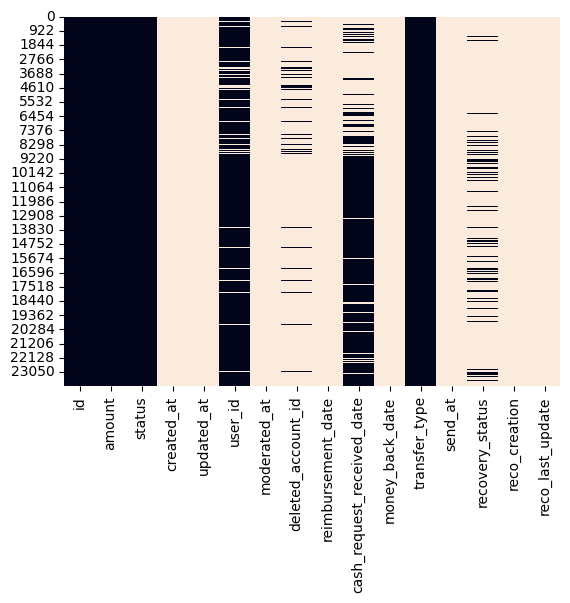

In [20]:
sns.heatmap(cash.isnull(), cbar=False)

In [ ]:
cash_cleaned = cash.dropna(axis=1, how ='all')
print(cash_cleaned.head(10))

     id  amount      status  user_id  deleted_account_id  \
0     5   100.0    rejected    804.0                 NaN   
1    70   100.0    rejected    231.0                 NaN   
2     7   100.0    rejected    191.0                 NaN   
3    10    99.0    rejected    761.0                 NaN   
4  1594   100.0    rejected   7686.0                 NaN   
5  2145   100.0  money_back   9489.0                 NaN   
6  3512   100.0    rejected  14631.0                 NaN   
7   654   100.0    rejected      NaN               309.0   
8  5672   100.0    canceled      NaN              2499.0   
9    71    90.0    rejected    897.0                 NaN   

  cash_request_received_date transfer_type recovery_status  
0                        NaN       regular             NaN  
1                        NaN       regular             NaN  
2                        NaN       regular             NaN  
3                        NaN       regular             NaN  
4                        NaN      

In [42]:
cash_cleaned['user_id'] = cash_cleaned['user_id'].astype('Int64')

In [ ]:
empty_columns = fees.columns[fees.isnull().all()]
print(f"Completely empty columns: {empty_columns}")


Completely empty columns: Index([], dtype='str')


<Axes: >

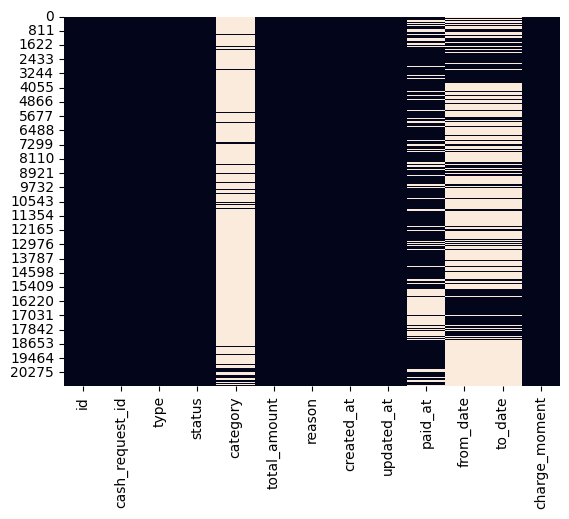

In [25]:
sns.heatmap(fees.isnull(), cbar=False)

In [28]:
from pandas import errors
#In the cash_clened df onvert the cash_request_received_date to datetime
cash_cleaned['cash_request_received_date'] = pd.to_datetime(cash_cleaned['cash_request_received_date'], errors='coerce')

In [ ]:
print(fees[].head(10))

      id  cash_request_id             type     status               category  \
0   6537          14941.0  instant_payment   rejected                    NaN   
1   6961          11714.0         incident   accepted  rejected_direct_debit   
2  16296          23371.0  instant_payment   accepted                    NaN   
3  20775          26772.0  instant_payment   accepted                    NaN   
4  11242          19350.0  instant_payment   accepted                    NaN   
5  17029          24052.0  instant_payment   accepted                    NaN   
6  19956          25983.0  instant_payment   accepted                    NaN   
7  14187          14839.0         incident   accepted  rejected_direct_debit   
8  20539          26572.0  instant_payment   accepted                    NaN   
9  15431          22106.0         postpone  cancelled                    NaN   

   total_amount                              reason  \
0           5.0  Instant Payment Cash Request 14941   
1        

In [ ]:
#In the fees df onvert all the date columns to datetime
date_cols = ['created_at', 'updated_at', 'paid_at', 'from_date']  

fees[date_cols] = fees[date_cols].apply(pd.to_datetime, errors='coerce')

print(fees['created_at'].dtype)

datetime64[us, UTC]


C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_30688\3079599455.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fees[date_cols] = fees[date_cols].apply(pd.to_datetime, errors='coerce')


In [36]:
#export data frames to clean csv
cash_cleaned.to_csv('cash_request_cleaned', index= False)
fees.to_csv('fees_cleaned', index = False)